# Algotytm przecinania się odcinków na płaszczyźnie

In [1]:
import numpy as np
import pandas as pd
from bitalg.tests.test4 import Test
from bitalg.visualizer.main import Visualizer
import sys
import heapq
import math
from sortedcontainers import SortedSet
from enum import Enum
from heapq import heappop, heappush, heapify


# Przydatne funkcje 

In [2]:
def draw_example_1():
    vis = Visualizer()
    line_segments = ((-0.5, 0.5), (8.5, 3.5),
                     (1, 3), (7, 5),
                     (2, 4), (5, 1),
                     (4.5, 3), (6.5, 6),
                     (0, 5), (5.5, 5.5))

    vis.add_line_segment(line_segments)
    vis.show()
    
def draw_example_2():
    vis = Visualizer()
    line_segments = ((-0.5, 0.5), (8.5, 3.5),
                     (1, 3), (7, 5),
                     (2, 4), (5, 1),
                     (4.5, 3), (6.5, 6),
                     (0, 5), (5.5, 5.5))
    points = [(4, 2),
              (2.5, 3.5),
              (5.5, 4.5)]

    vis.add_line_segment(line_segments)
    vis.add_point(points, color='red')
    vis.show()


### Wprowadzenie
Celem ćwiczenia jest implementacja i zapoznanie się z algorytmem wyznaczającym wszystkie przecięcia się odcinków na płaszczyźnie

### Przykładowy zbiór odcinków przed wyznaczeniem punktów przecięcia

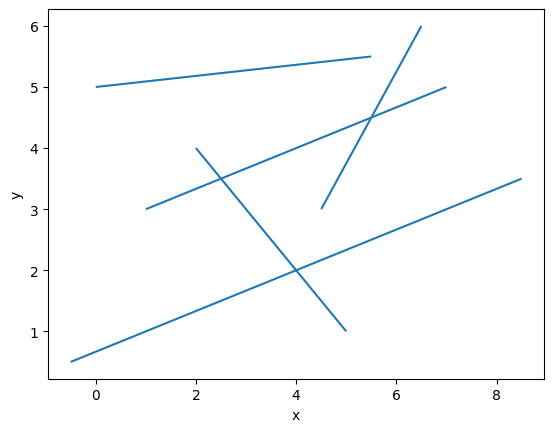

In [3]:
draw_example_1()

### Przykładowy zbiór odcinków po wyznaczenu punktów przecięcia

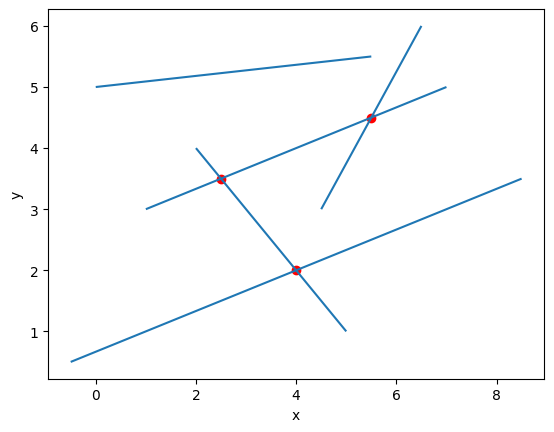

In [4]:
draw_example_2()

# Generowanie losowych odcinków na płaszczyźnie

Uzupełnij funkcję ```generate_uniform_sections```

In [5]:
import random
def generate_uniform_sections(max_x, max_y, n):
    """
    Funkcja generuje odcinki o współrzędnych rzeczywistych w postaci par punktów. 
    Żaden wygenerowany odcinek nie jest odcinkiem pionowym.
    Żadne dwa odcinki nie mają swoich końców o takiej samej współrzędnej x.
    Zakres współrzędnych: x -> (0, max_x), y -> (0, max_y)
    :param max_x: określa maksymalną wartość współrzednej x jaka może zostać wylosowana
    :param max_y: określa maksymalną wartość współrzednej y jaka może zostać wylosowana
    :param n: ilość generowanych odcinków
    :return: tablica odcinków w postaci krotek zawierających parę krotek współrzędnych punktów końcowych odcinków
    np. [((x1, y1), (x2, y2)), ((x3, y3), (x4, y4)),...]
    """
    sections = []
    used_x_coords = set()

    for _ in range(n):
        while True:
            x1 = random.uniform(0, max_x)
            if x1 in used_x_coords: continue
            
            x2 = random.uniform(0, max_x)
            if x2 in used_x_coords or x2 == x1: continue # pionowe i duplikaty zabronienie
            
            y1 = random.uniform(0, max_y)
            y2 = random.uniform(0, max_y)
            
            used_x_coords.add(x1)
            used_x_coords.add(x2)
            
            if x1 < x2:
                sections.append(((x1, y1), (x2, y2)))
            else:
                sections.append(((x2, y2), (x1, y1)))
            break
            
    return sections
    raise Exception("Unimplemented")

In [6]:
Test().runtest(1, generate_uniform_sections)

Lab 4, task 1:
	Test 1: Passed
	Test 2: Passed
	Test 3: Passed
Result: 3/3
Time: 0.121s


<span style="color:red">Ćw.</span> Wygeneruj $\large20$ losowych odcinków w przestrzeni 2D o współrzędnych z przedziału $\large x \in \langle 0,1000 \rangle$ oraz $\large y \in \langle 0,1000\rangle$. 

In [39]:
sections = generate_uniform_sections(1000, 1000, 15)

In [59]:
A = generate_uniform_sections(1000, 1000, 15)

Zwizualizuj otrzymane odcinki

[((176.9574120494779, 846.2758236969587), (427.62772197098764, 699.135369715197)), ((168.67538021862916, 362.9987205429546), (581.0149260152108, 586.0690451567057)), ((491.6719008970798, 80.47029964415864), (655.3732978999367, 24.33821711077644)), ((166.88219987807727, 339.5942603165554), (361.6921659660597, 335.56201636775904)), ((99.39147855835517, 286.4511544623145), (672.4289164981151, 832.1891203371706)), ((16.91124494099705, 851.2533157011427), (545.6286730829356, 743.7912564325032)), ((30.480372084874418, 126.41048560361712), (391.153957676217, 331.0679219174332)), ((121.61236911786145, 643.1820594123453), (474.14455854732705, 585.904862866458)), ((483.92066292440217, 453.93657120798616), (577.8272061853603, 703.647098788827)), ((479.57481351200283, 827.0355991613961), (992.8321223174754, 694.3724096995977)), ((466.24683884299134, 815.8070614326626), (877.6241464852941, 163.05855369006306)), ((463.6012842669641, 544.3000968131744), (540.6983663159317, 165.64764864327574)), ((371

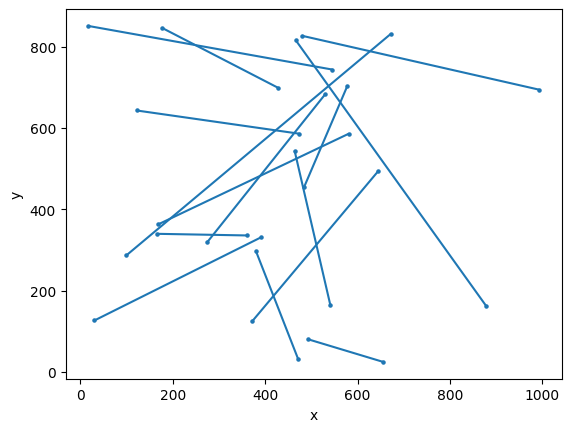

In [40]:
%matplotlib inline
vis = Visualizer()
vis.add_line_segment(sections)
vis.add_point([sections[i // 2][i % 2] for i in range(2 * len(sections))], s = 5)
vis.show()
print(sections)

Uzupełnij funkcję ```add_sections``` #interaktywne dodawanie odcinków przez rysowanie myszką

In [71]:
%matplotlib tk
import matplotlib.pyplot as plt
import matplotlib

class SegmentDrawer:
    def __init__(self, existing_sections=None, x_max=1000, y_max=1000):
        if existing_sections is None:
            self.sections = []
        else:
            self.sections = existing_sections.copy()
            
        self.current_points = [] 
        self.xs_set = set()
        
        for s in self.sections:
            self.xs_set.add(s[0][0])
            self.xs_set.add(s[1][0])

        self.fig, self.ax = plt.subplots(figsize=(8, 8))
        self.ax.set_xlim(0, x_max)
        self.ax.set_ylim(0, y_max)
        self.ax.set_title(f"LPM: Dodaj punkt | PPM: Zakończ\nLiczba odcinków: {len(self.sections)}")
        self.ax.grid(True, linestyle=':', alpha=0.6)

        for s in self.sections:
            self.ax.plot([s[0][0], s[1][0]], [s[0][1], s[1][1]], 'b-', alpha=0.6)
            self.ax.scatter([s[0][0], s[1][0]], [s[0][1], s[1][1]], color='blue', s=10, alpha=0.6)

        self.cid = self.fig.canvas.mpl_connect('button_press_event', self.onclick)
        
        print("Rozpoczęto rysowanie. Kliknij lewym, aby stawiać punkty.")

    def onclick(self, event):
        if event.inaxes != self.ax: return

        # dodwanie odcinkow (lewy przycisk myszy)
        if event.button == 1:
            x, y = event.xdata, event.ydata
            #unikalnosc x    
            if any(abs(x - existing_x) < 1e-9 for existing_x in self.xs_set):
                self.ax.set_title("BŁĄD: Ta współrzędna X już istnieje! Kliknij gdzie indziej.")
                self.fig.canvas.draw()
                return
            #pionowosc
            if len(self.current_points) == 1:
                p1_x = self.current_points[0][0]
                if abs(x - p1_x) < 1e-9:
                    self.ax.set_title("BŁĄD: Odcinek nie może być pionowy! Kliknij gdzie indziej.")
                    self.fig.canvas.draw()
                    return

            self.current_points.append((x, y))
            self.ax.scatter(x, y, color='red', s=20, zorder=5)
            self.fig.canvas.draw()

            # jak mamy dwa punkty tworzymy odcinek
            if len(self.current_points) == 2:
                p1 = self.current_points[0]
                p2 = self.current_points[1]
                
                if p1[0] > p2[0]: p1, p2 = p2, p1
                
                new_section = (p1, p2)
                self.sections.append(new_section)
                
                self.xs_set.add(p1[0])
                self.xs_set.add(p2[0])
                
                self.ax.plot([p1[0], p2[0]], [p1[1], p2[1]], 'r-', linewidth=2)
                self.ax.set_title(f"Dodano odcinek! Razem: {len(self.sections)}")
                self.fig.canvas.draw()
                
                self.current_points = []

        # prawy przycisk mysz konczy program
        elif event.button == 3:
            self.finish()

    def finish(self):
        self.fig.canvas.mpl_disconnect(self.cid)
        self.ax.set_title(f"Zakończono! Finalna liczba odcinków: {len(self.sections)}")
        self.fig.canvas.draw()
        print(f"Zakończono rysowanie. Zapisano {len(self.sections)} odcinków.")

    def get_sections(self):
        return self.sections

In [74]:
sections_random = [] 
drawer = SegmentDrawer(sections_random, x_max=1000, y_max=1000)

Rozpoczęto rysowanie. Kliknij lewym, aby stawiać punkty.
Zakończono rysowanie. Zapisano 7 odcinków.


In [75]:
%matplotlib inline

E = drawer.get_sections()
print(f"liczba odcinkow: {len(E)} ")
print(E)

liczba odcinkow: 7 
[((np.float64(135.48387096774192), np.float64(827.922077922078)), (np.float64(840.3225806451612), np.float64(462.6623376623377))), ((np.float64(85.48387096774192), np.float64(202.922077922078)), (np.float64(925.8064516129032), np.float64(659.0909090909091))), ((np.float64(254.83870967741936), np.float64(170.45454545454547)), (np.float64(358.0645161290323), np.float64(870.1298701298703))), ((np.float64(16.129032258064512), np.float64(56.81818181818184)), (np.float64(88.70967741935482), np.float64(920.4545454545455))), ((np.float64(503.2258064516129), np.float64(972.4025974025976)), (np.float64(914.516129032258), np.float64(887.987012987013))), ((np.float64(906.4516129032259), np.float64(170.45454545454547)), (np.float64(980.6451612903224), np.float64(782.4675324675326))), ((np.float64(170.96774193548387), np.float64(63.31168831168833)), (np.float64(677.4193548387096), np.float64(108.7662337662338)))]


Uzupełnij funkcję ```is_intersection```

In [50]:
EPS = 1e-9
def orient(a, b, c):
    val = (b[0] - a[0]) * (c[1] - a[1]) - (b[1] - a[1]) * (c[0] - a[0])
    if abs(val) < EPS: return 0
    return 1 if val > 0 else 2

def on_segment(p, a, b):
    #czy punkt p leży na odcinku ab
    return min(a[0], b[0]) - EPS <= p[0] <= max(a[0], b[0]) + EPS and \
           min(a[1], b[1]) - EPS <= p[1] <= max(a[1], b[1]) + EPS

def do_intersect(s1, s2):
    # czy s1 i s2 sie przecinaja
    p1, q1 = s1
    p2, q2 = s2
    
    o1 = orient(p1, q1, p2)
    o2 = orient(p1, q1, q2)
    o3 = orient(p2, q2, p1)
    o4 = orient(p2, q2, q1)

    # Ogólny przypadek
    if o1 != o2 and o3 != o4: return True
    
    # Przypadki specjalne (współliniowość, tj. końce na odcinku)
    if o1 == 0 and on_segment(p2, p1, q1): return True
    if o2 == 0 and on_segment(q2, p1, q1): return True
    if o3 == 0 and on_segment(p1, p2, q2): return True
    if o4 == 0 and on_segment(q1, p2, q2): return True
    
    return False

In [104]:
from sortedcontainers import SortedList

# --- Klasy i Funkcje Pomocnicze ---

class Segment:
    sweep_x = 0.0 

    def __init__(self, p1, p2, idx):
        self.p1 = p1
        self.p2 = p2
        self.idx = idx
        
        if p1[0] != p2[0]:
            self.a = (p2[1] - p1[1]) / (p2[0] - p1[0])
            self.b = p1[1] - self.a * p1[0]
        else:
            self.a = 0
            self.b = p1[1]

    def get_y(self): 
        return self.a * Segment.sweep_x + self.b

    def __lt__(self, other):
        return self.get_y() < other.get_y()

def orient(a, b, c):
    val = (b[0] - a[0]) * (c[1] - a[1]) - (b[1] - a[1]) * (c[0] - a[0])
    if abs(val) < 1e-10: return 0
    return 1 if val > 0 else 2

def on_segment(p, a, b):
    return min(a[0], b[0]) <= p[0] <= max(a[0], b[0]) and \
           min(a[1], b[1]) <= p[1] <= max(a[1], b[1])

def check_segments_intersect(seg1, seg2):
    p1, q1 = seg1.p1, seg1.p2
    p2, q2 = seg2.p1, seg2.p2
    
    o1 = orient(p1, q1, p2); o2 = orient(p1, q1, q2)
    o3 = orient(p2, q2, p1); o4 = orient(p2, q2, q1)

    if o1 != o2 and o3 != o4: return True
    if o1 == 0 and on_segment(p2, p1, q1): return True
    if o2 == 0 and on_segment(q2, p1, q1): return True
    if o3 == 0 and on_segment(p1, p2, q2): return True
    if o4 == 0 and on_segment(q1, p2, q2): return True
    return False

def find_intersection_point(seg1, seg2):
    """Funkcja pomocnicza potrzebna tylko do narysowania czerwonej kropki."""
    p1, q1 = seg1.p1, seg1.p2
    p2, q2 = seg2.p1, seg2.p2
    
    A1 = q1[1] - p1[1]; B1 = p1[0] - q1[0]; C1 = A1*p1[0] + B1*p1[1]
    A2 = q2[1] - p2[1]; B2 = p2[0] - q2[0]; C2 = A2*p2[0] + B2*p2[1]
    
    det = A1*B2 - A2*B1
    if abs(det) < 1e-10: return None # Równoległe (w teorii obsłużone wcześniej)
    x = (B2*C1 - B1*C2) / det
    y = (A1*C2 - A2*C1) / det
    return (x, y)

# --- Główna funkcja z wizualizacją ---

def is_intersection_with_visualization(sections):
    vis = Visualizer()
    
    # 1. TŁO: Wszystkie odcinki na jasnoszaro
    vis.add_line_segment(sections, color='lightgray')
    
    # Obliczenie zakresu Y dla rysowania miotły
    if sections:
        all_y = [p[1] for s in sections for p in s]
        min_y, max_y = min(all_y) - 1, max(all_y) + 1
    else:
        min_y, max_y = 0, 10

    events = []
    seg_objects = []

    # Inicjalizacja zdarzeń
    for i, s in enumerate(sections):
        p1, p2 = s
        if p1[0] < p2[0]: left, right = p1, p2
        else: left, right = p2, p1
        
        seg = Segment(left, right, i)
        seg_objects.append(seg)
        
        events.append((left[0], 0, i))
        events.append((right[0], 1, i))

    events.sort(key=lambda e: (e[0], e[1]))
    
    # Struktura stanu T oparta na SortedList
    active_segments = SortedList()

    for x, type, idx in events:
        Segment.sweep_x = x
        current_seg = seg_objects[idx]
        
        # --- WIZUALIZACJA KROKU ---
        # Miotła
        sweep_vis = vis.add_line_segment(((x, min_y), (x, max_y)), color='red')
        
        # Aktywne odcinki (niebieskie)
        active_lines_vis = []
        for sec in active_segments:
            l = vis.add_line_segment((sec.p1, sec.p2), color='blue')
            active_lines_vis.append(l)
            
        # Punkt zdarzenia
        pt = current_seg.p1 if type == 0 else current_seg.p2
        c = 'green' if type == 0 else 'orange'
        pt_vis = vis.add_point([pt], color=c)
        # --------------------------

        if type == 0: # START
            active_segments.add(current_seg)
            pos = active_segments.index(current_seg)
            
            # Sprawdź górnego sąsiada
            if pos + 1 < len(active_segments):
                upper_neighbor = active_segments[pos + 1]
                if check_segments_intersect(current_seg, upper_neighbor):
                    # Znaleziono!
                    p = find_intersection_point(current_seg, upper_neighbor)
                    if p: vis.add_point([p], color='red')
                    return True, vis
            
            # Sprawdź dolnego sąsiada
            if pos > 0:
                lower_neighbor = active_segments[pos - 1]
                if check_segments_intersect(current_seg, lower_neighbor):
                    p = find_intersection_point(current_seg, lower_neighbor)
                    if p: vis.add_point([p], color='red')
                    return True, vis

        else: # KONIEC
            if current_seg in active_segments:
                pos = active_segments.index(current_seg)
                
                lower_neighbor = active_segments[pos - 1] if pos > 0 else None
                upper_neighbor = active_segments[pos + 1] if pos + 1 < len(active_segments) else None
                
                active_segments.remove(current_seg)
                
                if lower_neighbor and upper_neighbor:
                    if check_segments_intersect(lower_neighbor, upper_neighbor):
                        p = find_intersection_point(lower_neighbor, upper_neighbor)
                        if p: vis.add_point([p], color='red')
                        return True, vis

        # Sprzątanie tymczasowych elementów wizualizacji
        vis.remove_figure(sweep_vis)
        vis.remove_figure(pt_vis)
        for l in active_lines_vis: vis.remove_figure(l)

    return False, vis

In [105]:
Test().runtest(2, is_intersection)

Lab 4, task 2:
	Test 1: Passed
	Test 2: Passed
	Test 3: Passed
Result: 3/3
Time: 0.002s


### W jaki sposób zaimplementowałeś struktura stanu (stan miotły) oraz struktura zdarzeń w Twoim programie?

In [106]:
#Strukturę zdarzeń zaimplementowałem jako standardową listę krotek posortowaną rosnąco według współrzędnej x, 
#natomiast strukturę stanu (miotły) oparłem na obiekcie SortedList z biblioteki sortedcontainers, który przechowuje
#aktywne odcinki i utrzymuje je w dynamicznym porządku względem ich aktualnej współrzędnej y na linii zamiatania.

Uzupełnij funkcję ```is_intersection_with_visualization```

In [107]:
from sortedcontainers import SortedSet
from heapq import heappush, heappop

class Segment:
    sweep_x = 0.0 

    def __init__(self, p1, p2, idx):
        self.p1 = p1
        self.p2 = p2
        self.idx = idx
        
        if p1[0] != p2[0]:
            self.a = (p2[1] - p1[1]) / (p2[0] - p1[0])
            self.b = p1[1] - self.a * p1[0]
        else:
            self.a = 0
            self.b = p1[1]

    def get_y(self): 
        return self.a * Segment.sweep_x + self.b

    def __lt__(self, other):
        y1 = self.get_y()
        y2 = other.get_y()
        if abs(y1 - y2) > 1e-9:
            return y1 < y2
        return self.idx < other.idx

def orient(a, b, c):
    val = (b[0] - a[0]) * (c[1] - a[1]) - (b[1] - a[1]) * (c[0] - a[0])
    if abs(val) < 1e-10: return 0
    return 1 if val > 0 else 2

def on_segment(p, a, b):
    return min(a[0], b[0]) <= p[0] <= max(a[0], b[0]) and \
           min(a[1], b[1]) <= p[1] <= max(a[1], b[1])

def check_segments_intersect(seg1, seg2):
    p1, q1 = seg1.p1, seg1.p2
    p2, q2 = seg2.p1, seg2.p2
    
    o1 = orient(p1, q1, p2); o2 = orient(p1, q1, q2)
    o3 = orient(p2, q2, p1); o4 = orient(p2, q2, q1)

    if o1 != o2 and o3 != o4: return True
    if o1 == 0 and on_segment(p2, p1, q1): return True
    if o2 == 0 and on_segment(q2, p1, q1): return True
    if o3 == 0 and on_segment(p1, p2, q2): return True
    if o4 == 0 and on_segment(q1, p2, q2): return True
    return False

def find_intersection_point(seg1, seg2):
    p1, q1 = seg1.p1, seg1.p2
    p2, q2 = seg2.p1, seg2.p2
    
    A1 = q1[1] - p1[1]; B1 = p1[0] - q1[0]; C1 = A1*p1[0] + B1*p1[1]
    A2 = q2[1] - p2[1]; B2 = p2[0] - q2[0]; C2 = A2*p2[0] + B2*p2[1]
    
    det = A1*B2 - A2*B1
    if abs(det) < 1e-10: return None
    x = (B2*C1 - B1*C2) / det
    y = (A1*C2 - A2*C1) / det
    return (x, y)

def is_intersection_with_visualization(sections):
    vis = Visualizer()
    vis.add_line_segment(sections, color='lightgray')
    
    if sections:
        all_y = [p[1] for s in sections for p in s]
        min_y, max_y = min(all_y) - 1, max(all_y) + 1
    else:
        min_y, max_y = 0, 10

    events = []
    seg_objects = []

    for i, s in enumerate(sections):
        p1, p2 = s
        if p1[0] < p2[0]: left, right = p1, p2
        else: left, right = p2, p1
        
        seg = Segment(left, right, i)
        seg_objects.append(seg)
        
        events.append((left[0], 0, i))
        events.append((right[0], 1, i))

    events.sort(key=lambda e: (e[0], e[1]))
    active_segments = SortedSet()

    for x, type, idx in events:
        Segment.sweep_x = x
        current_seg = seg_objects[idx]
        
        sweep_vis = vis.add_line_segment(((x, min_y), (x, max_y)), color='red')
        
        active_lines_vis = []
        for sec in active_segments:
            l = vis.add_line_segment((sec.p1, sec.p2), color='blue')
            active_lines_vis.append(l)
            
        pt = current_seg.p1 if type == 0 else current_seg.p2
        c = 'green' if type == 0 else 'orange'
        pt_vis = vis.add_point([pt], color=c)

        if type == 0:
            active_segments.add(current_seg)
            pos = active_segments.index(current_seg)
            
            if pos + 1 < len(active_segments):
                upper_neighbor = active_segments[pos + 1]
                if check_segments_intersect(current_seg, upper_neighbor):
                    p = find_intersection_point(current_seg, upper_neighbor)
                    if p: vis.add_point([p], color='red')
                    return True, vis
            
            if pos > 0:
                lower_neighbor = active_segments[pos - 1]
                if check_segments_intersect(current_seg, lower_neighbor):
                    p = find_intersection_point(current_seg, lower_neighbor)
                    if p: vis.add_point([p], color='red')
                    return True, vis

        else:
            if current_seg in active_segments:
                pos = active_segments.index(current_seg)
                
                lower_neighbor = active_segments[pos - 1] if pos > 0 else None
                upper_neighbor = active_segments[pos + 1] if pos + 1 < len(active_segments) else None
                
                active_segments.remove(current_seg)
                
                if lower_neighbor and upper_neighbor:
                    if check_segments_intersect(lower_neighbor, upper_neighbor):
                        p = find_intersection_point(lower_neighbor, upper_neighbor)
                        if p: vis.add_point([p], color='red')
                        return True, vis

        vis.remove_figure(sweep_vis)
        vis.remove_figure(pt_vis)
        for l in active_lines_vis: vis.remove_figure(l)

    return False, vis

Czy znaleziono przecięcie? True


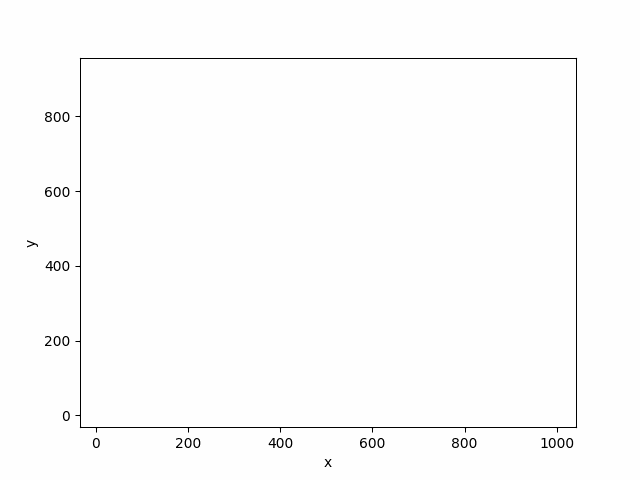

In [22]:
result, vis = is_intersection_with_visualization(sections)

print("Czy znaleziono przecięcie?", result)

# 3. Wyświetlamy GIF
# interval=200 oznacza 200ms na jeden krok (ruch miotły)
vis.show_gif(interval=200)

Uzupełnij funkcję ```find_intersections```

In [27]:
from heapq import heappush, heappop, heapify
import math

try:
    from sortedcontainers import SortedSet
except ImportError:
    raise ImportError("Brak biblioteki sortedcontainers. Zainstaluj ją: !pip install sortedcontainers")

EPS = 1e-9

class PType:
    LEFT = 0
    RIGHT = 1
    INTERSECT = 2

class MyPoint:
    def __init__(self, x, y, type, origin_section_idx, second_section_idx=None):
        self.x = x
        self.y = y
        self.type = type
        self.origin_section_idx = origin_section_idx
        self.second_section_idx = second_section_idx

    def __lt__(self, other):
        if abs(self.x - other.x) > EPS:
            return self.x < other.x
        if abs(self.y - other.y) > EPS:
            return self.y < other.y
        return self.type < other.type
    
    def toTuple(self):
        return (self.x, self.y)

class MySection:
    sweep_x = 0.0

    def __init__(self, p1, p2, idx):
        self.p1 = p1
        self.p2 = p2
        self.original_index = idx
        self.idx = idx
        
        if abs(p1.x - p2.x) > EPS:
            self.a = (p2.y - p1.y) / (p2.x - p1.x)
            self.b = p1.y - self.a * p1.x
        else:
            self.a = 0
            self.b = p1.y

    @staticmethod
    def update_sweep_line(x):
        MySection.sweep_x = x

    def get_y(self):
        return self.a * MySection.sweep_x + self.b

    def __lt__(self, other):
        y1 = self.get_y()
        y2 = other.get_y()
        if abs(y1 - y2) > EPS:
            return y1 < y2
        return self.idx < other.idx
    
    def __hash__(self):
        return hash(self.idx)
    
    def __eq__(self, other):
        return self.idx == other.idx

def check_intersections(s1, s2):
    x1, y1 = s1.p1.x, s1.p1.y
    x2, y2 = s1.p2.x, s1.p2.y
    x3, y3 = s2.p1.x, s2.p1.y
    x4, y4 = s2.p2.x, s2.p2.y
    
    denom = (y4 - y3) * (x2 - x1) - (x4 - x3) * (y2 - y1)
    if abs(denom) < EPS: return None
    
    ua = ((x4 - x3) * (y1 - y3) - (y4 - y3) * (x1 - x3)) / denom
    ub = ((x2 - x1) * (y1 - y3) - (y2 - y1) * (x1 - x3)) / denom
    
    if 0 <= ua <= 1 and 0 <= ub <= 1:
        x = x1 + ua * (x2 - x1)
        y = y1 + ua * (y2 - y1)
        return MyPoint(x, y, PType.INTERSECT, -1)
    return None

def process_neighbor(idx1, idx2, T, checked_pairs, sections_classes, points, Q):
    if idx1 < 0 or idx2 >= len(T): return

    s1 = T[idx1]
    s2 = T[idx2]
    
    i, j = s1.idx, s2.idx
    if i > j: i, j = j, i
    
    if (i, j) not in checked_pairs:
        checked_pairs.add((i, j))
        
        p = check_intersections(sections_classes[i], sections_classes[j])
        if p:
            if p.x >= MySection.sweep_x - EPS:
                points.append((p.toTuple(), s1.idx + 1, s2.idx + 1))
                
                heappush(Q, MyPoint(p.x, p.y, PType.INTERSECT, s1.idx, s2.idx))

def find_intersections(sections):
    Q = [] 
    T = SortedSet() 
    checked_pairs = set()
    sections_classes = []
    points = [] 

    for i in range(len(sections)):
        p1, p2 = sections[i]
        if p1[0] < p2[0]:
            left, right = p1, p2
        else:
            left, right = p2, p1
        
        left_pt = MyPoint(left[0], left[1], PType.LEFT, i)
        right_pt = MyPoint(right[0], right[1], PType.RIGHT, i)
        
        heappush(Q, left_pt)
        heappush(Q, right_pt)
        
        sections_classes.append(MySection(left_pt, right_pt, i))

    while Q:
        e = heappop(Q)
        
        if e.type == PType.LEFT:
            MySection.update_sweep_line(e.x)
            curr = sections_classes[e.origin_section_idx]
            T.add(curr)
            
            idx = T.index(curr)
            process_neighbor(idx - 1, idx, T, checked_pairs, sections_classes, points, Q)
            process_neighbor(idx, idx + 1, T, checked_pairs, sections_classes, points, Q)
            
        elif e.type == PType.RIGHT:
            MySection.update_sweep_line(e.x)
            curr = sections_classes[e.origin_section_idx]
            if curr in T:
                idx = T.index(curr)
                process_neighbor(idx - 1, idx + 1, T, checked_pairs, sections_classes, points, Q)
                T.remove(curr)
                
        elif e.type == PType.INTERSECT:
            s_i = sections_classes[e.origin_section_idx]
            s_j = sections_classes[e.second_section_idx]
            
            if s_i in T and s_j in T:
                MySection.update_sweep_line(e.x - EPS)
                
                try:
                    T.remove(s_i)
                    T.remove(s_j)
                except ValueError:
                    pass

                MySection.update_sweep_line(e.x + EPS)
                
                T.add(s_i)
                T.add(s_j)
                
                idx_i = T.index(s_i)
                idx_j = T.index(s_j)
                
                process_neighbor(idx_i - 1, idx_i, T, checked_pairs, sections_classes, points, Q)
                process_neighbor(idx_i, idx_i + 1, T, checked_pairs, sections_classes, points, Q)
                process_neighbor(idx_j - 1, idx_j, T, checked_pairs, sections_classes, points, Q)
                process_neighbor(idx_j, idx_j + 1, T, checked_pairs, sections_classes, points, Q)

    return points

In [28]:
Test().runtest(3, find_intersections)

Lab 4, task 3:
	Test 1: Passed
	Test 2: Passed
	Test 3: Passed
Result: 3/3
Time: 0.003s


Uzupełnij funkcję ```find_intersections_with_visualization```

In [85]:
def find_intersections_with_visualization(sections):
    vis = Visualizer()
    
    # 1. TŁO: Rysujemy wszystkie odcinki na JASNOSZARO, żeby aktywne się wyróżniały
    vis.add_line_segment(sections, color='lightgray')
    
    if sections:
        all_y = [p[1] for s in sections for p in s]
        min_y, max_y = min(all_y) - 1, max(all_y) + 1
    else:
        min_y, max_y = 0, 10

    Q = []
    T = SortedSet()
    checked_pairs = set()
    sections_classes = []
    points = []

    for i in range(len(sections)):
        p1, p2 = sections[i]
        if p1[0] < p2[0]: left, right = p1, p2
        else: left, right = p2, p1
        left_pt = MyPoint(left[0], left[1], PType.LEFT, i)
        right_pt = MyPoint(right[0], right[1], PType.RIGHT, i)
        heappush(Q, left_pt); heappush(Q, right_pt)
        sections_classes.append(MySection(left_pt, right_pt, i))

    while Q:
        e = heappop(Q)
        
        MySection.update_sweep_line(e.x)
        
        # --- WIZUALIZACJA ---
        # 1. MIOTŁA (Czerwona linia pionowa)
        sweep_vis = vis.add_line_segment(((e.x, min_y), (e.x, max_y)), color='red')
        
        # 2. AKTYWNE ODCINKI (Niebieskie, wyróżniające się na tle szarych)
        active_lines_vis = []
        for sec in T:
            # Rysujemy odcinek
            l = vis.add_line_segment(((sec.p1.x, sec.p1.y), (sec.p2.x, sec.p2.y)), color='blue')
            active_lines_vis.append(l)
            
        # 3. PUNKT ZDARZENIA (Kropka, którą właśnie przetwarzamy)
        c = 'green' if e.type == PType.LEFT else ('orange' if e.type == PType.RIGHT else 'red')
        pt_vis = vis.add_point([(e.x, e.y)], color=c)
        # --------------------

        if e.type == PType.LEFT:
            curr = sections_classes[e.origin_section_idx]
            T.add(curr)
            idx = safe_index(T, curr)
            if idx != -1:
                process_neighbor(idx - 1, idx, T, checked_pairs, sections_classes, points, Q)
                process_neighbor(idx, idx + 1, T, checked_pairs, sections_classes, points, Q)
            
        elif e.type == PType.RIGHT:
            curr = sections_classes[e.origin_section_idx]
            if curr in T:
                idx = safe_index(T, curr)
                if idx != -1:
                    process_neighbor(idx - 1, idx + 1, T, checked_pairs, sections_classes, points, Q)
                safe_remove(T, curr)
                
        elif e.type == PType.INTERSECT:
            s_i = sections_classes[e.origin_section_idx]
            s_j = sections_classes[e.second_section_idx]
            
            if s_i in T and s_j in T:
                MySection.update_sweep_line(e.x - EPS)
                safe_remove(T, s_i); safe_remove(T, s_j)
                
                MySection.update_sweep_line(e.x + EPS)
                T.add(s_i); T.add(s_j)
                
                idx_i = safe_index(T, s_i)
                idx_j = safe_index(T, s_j)
                
                if idx_i != -1:
                    process_neighbor(idx_i - 1, idx_i, T, checked_pairs, sections_classes, points, Q)
                    process_neighbor(idx_i, idx_i + 1, T, checked_pairs, sections_classes, points, Q)
                if idx_j != -1:
                    process_neighbor(idx_j - 1, idx_j, T, checked_pairs, sections_classes, points, Q)
                    process_neighbor(idx_j, idx_j + 1, T, checked_pairs, sections_classes, points, Q)
                
                # 4. PUNKT PRZECIĘCIA (Zostaje na stałe jako czerwona kropka)
                vis.add_point([(e.x, e.y)], color='red')

        vis.remove_figure(sweep_vis)
        vis.remove_figure(pt_vis)
        for l in active_lines_vis: vis.remove_figure(l)

    return points, vis

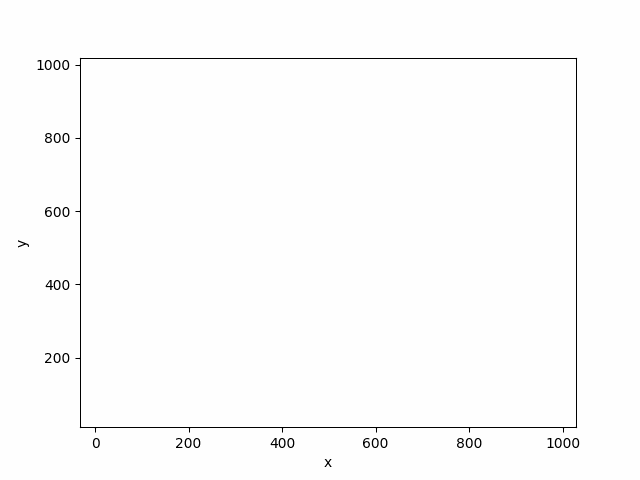

In [86]:
result_points2, vis2 = find_intersections_with_visualization(sections)

vis2.show_gif(interval=100)

#vis.save_gif("zamiatanie.gif", interval=100)

### Czy konieczne były zmiany w strukturze zdarzeń. Jeśli tak, to jakie? Czy w przypadku obu algorytmów konieczne są takie same struktury zdarzeń?
### Odpowiedź uzasadnij. 

In [31]:
# nie takie same storkory zdarzen nie są konieczne, w is_intersection algorytm konczy dzialanie natychmiast po znalezieniu pierwszego
# przeciecia. Nie musimy przetwarzac punktu przeciecia jako zdarzenia, bo w tym momencie program sie juz konczy zwracajaz True, zbior
# zdzarzen jest staly tylko poczatki i konce odcinkow, natomiast w drugim algorytmie: find_intersections konieczna jest kolejka
# priorytetowa (kopiec), bo algorytm musi dzialac dalej po znalezieniu przeciecia. Punkt przeciecia staje się nowym zdarzeniem, ktore musi
# zostac dynamicznie dodadne do koledjki w trakcie dzialania pętli. W punkcie tym nastepuje zmiana kolejnosci odcinkow w strukturze stanu,
# co pozwala wykryć kolejne przeciacia z nowymi sąsiadami

### Jak obsługiwane są zdarzenia początku odcinka, końca odcinka i przecięcia odcinków z uwzględnianiem wybranych struktur danych?

In [56]:
# zdarzenie początku odcinka skutkuje dodaniem go do struktury stanu T i sprawdzeniem przecięć z jego bezpośrednimi sąsiadami,
# zdarzenie końca usuwa odcinek z T oraz weryfikuje, czy jego dawni sąsiedzi (górny i dolny) się przecinają, natomiast w punkcie
# przecięcia następuje zamiana kolejności odpowiednich odcinków w T, po czym sprawdzane są przecięcia z ich nowymi sąsiadami,
# a znalezione kolizje trafiają do kolejki priorytetowej Q.

### Samemu zaprojektuj test, który uwzględnia taki układ odcinków, przy którym pewne przecięcia będą wykrywane więcej niż jeden raz

In [57]:
# testing_sections = ???

In [58]:
### Czy Twój program uwzględnia powyższy przypadek? Jeśli tak, to jak? 

In [59]:
# Odpowiedź here

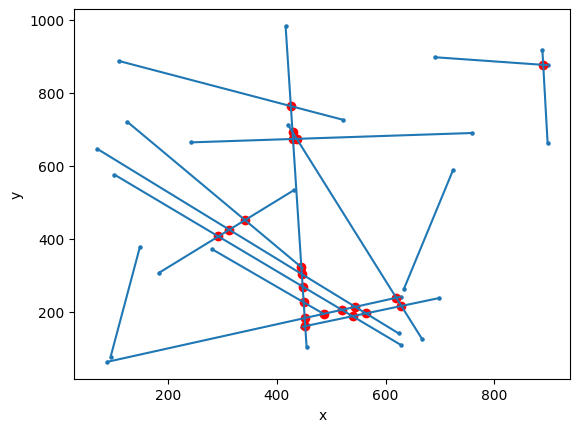

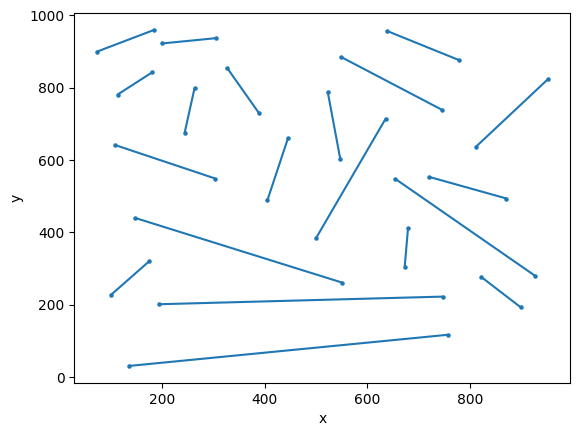

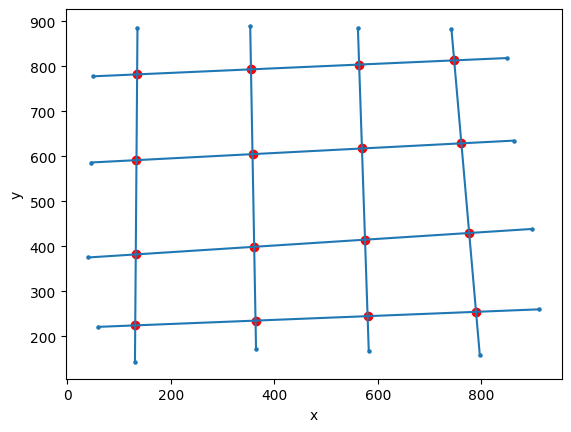

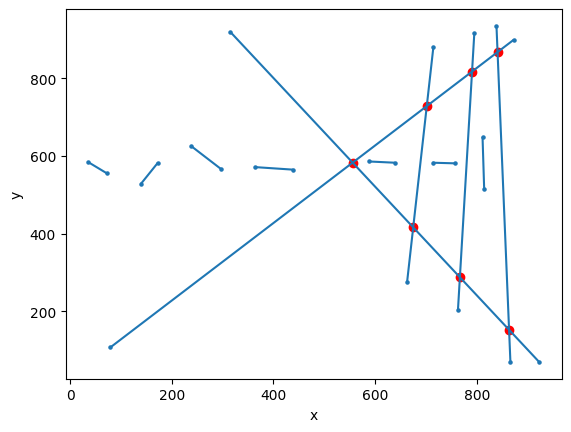

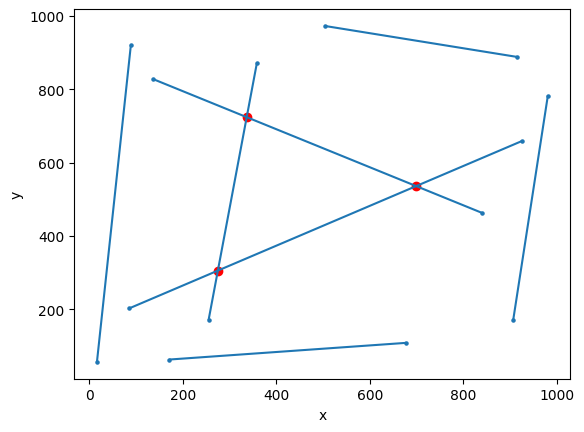

In [103]:
%matplotlib inline
for sections in [A, B, C, D, E]:
    result_points, _ = find_intersections_with_visualization(sections)
    vis = Visualizer()
    vis.add_line_segment(sections)
    vis.add_point([sections[i // 2][i % 2] for i in range(2 * len(sections))], s = 5)
    for p, _, _ in result_points:
        vis.add_point(p, c = "red")
    vis.show()
    #print(sections)

[((421.00738319467956, 710.3043075377908), (666.94683285474, 125.12275123391814)), ((94.29968556119861, 76.53347301063395), (147.8795402888262, 375.8536815113123)), ((633.6180693733143, 261.8294924614608), (723.9658408336834, 587.3840849969916)), ((446.0477448011664, 158.26802639844107), (699.0000398400169, 237.22807008187252)), ((242.70908796740974, 663.5949693320089), (759.0566270805576, 689.2146222381622)), ((416.05663457509655, 982.5704044132718), (454.6911439601138, 103.09197349749944)), ((124.47711815787133, 720.4799442854165), (448.4939980414883, 317.3156205055333)), ((280.2847955073173, 371.35152369020574), (486.8821328000373, 193.040002050187)), ((690.0796861179981, 896.8835785295543), (898.43799012631, 875.0249784735813)), ((87.4580616948244, 62.08431359876687), (627.8926336960011, 240.5639527517306)), ((183.9328653874891, 306.8626885883702), (431.0068278161469, 532.3264870277891)), ((888.3849091230297, 915.9600476261725), (898.0015404663048, 661.3072985267155)), ((101.223919

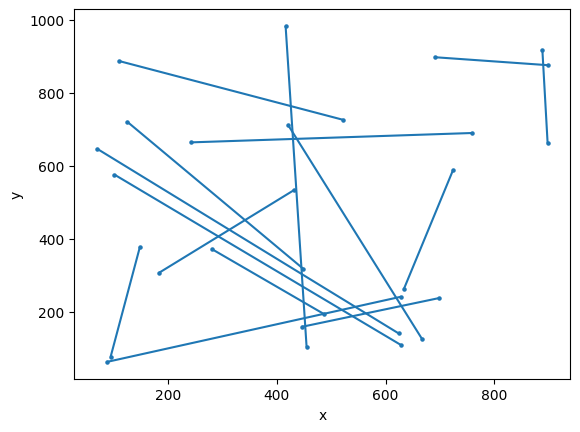

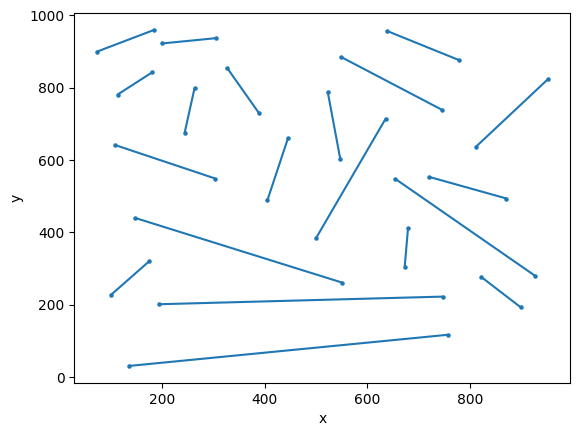

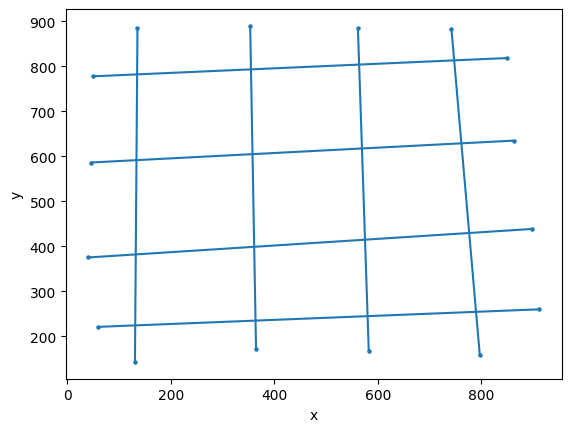

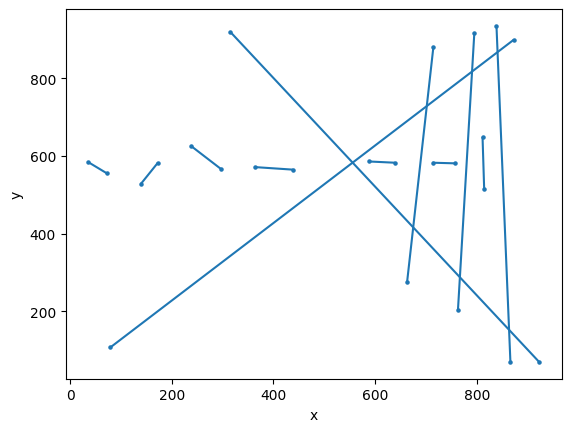

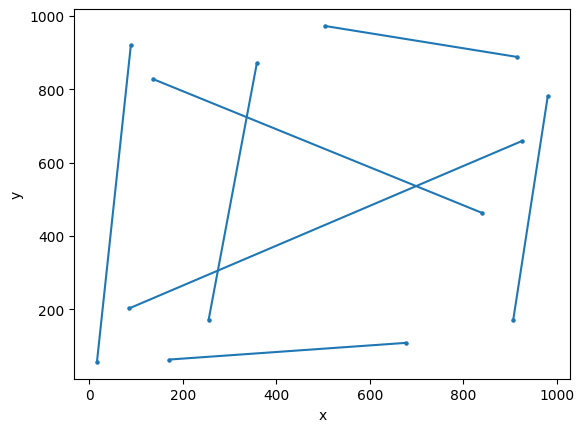

In [76]:
%matplotlib inline
for sections in [A, B, C, D, E]:
    vis = Visualizer()
    vis.add_line_segment(sections)
    vis.add_point([sections[i // 2][i % 2] for i in range(2 * len(sections))], s = 5)
    vis.show()
    print(sections)

In [98]:
result, vis = is_intersection_with_visualization(A)

#print("Czy znaleziono przecięcie?", result)

# 3. Wyświetlamy GIF
# interval=200 oznacza 200ms na jeden krok (ruch miotły)
vis.show_gif(interval=200)
vis.save_gif("A_1", interval=200)

In [88]:
result_points2, vis2 = find_intersections_with_visualization(A)

#vis2.show_gif(interval=100)
vis2.save_gif("A_2", interval=200)

In [99]:
result, vis = is_intersection_with_visualization(B)

#print("Czy znaleziono przecięcie?", result)

# 3. Wyświetlamy GIF
# interval=200 oznacza 200ms na jeden krok (ruch miotły)
vis.save_gif("B_1", interval=200)

In [90]:
result_points2, vis2 = find_intersections_with_visualization(B)

#vis2.show_gif(interval=100)
vis2.save_gif("B_2", interval=200)

In [100]:
result, vis = is_intersection_with_visualization(C)
vis.save_gif("C_1", interval=200)

In [92]:
result_points2, vis2 = find_intersections_with_visualization(C)

#vis2.show_gif(interval=100)
vis2.save_gif("C_2", interval=200)

In [101]:
result, vis = is_intersection_with_visualization(D)
vis.save_gif("D_1", interval=200)

In [94]:
result_points2, vis2 = find_intersections_with_visualization(D)

#vis2.show_gif(interval=100)
vis2.save_gif("D_2", interval=200)

In [102]:
result, vis = is_intersection_with_visualization(E)
vis.save_gif("E_1", interval=200)

In [96]:
result_points2, vis2 = find_intersections_with_visualization(E)

#vis2.show_gif(interval=100)
vis2.save_gif("E_2", interval=200)

### Zadanie dodatkowe
Zaimplementuj inną strukturę stanu. Opisz ją w sprawozdaniu. Porównaj efektywność algorytmu dla obu struktur robiąc testy na odpowiednio dużych zestawach odcinków.